<a href="https://colab.research.google.com/github/FritzAriza/TDG_Ariza_Roman/blob/main/Red_CNN_TG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.16.2

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.7/590.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.16.2 which is incompatible.


In [2]:
%pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 8.6 MB/s eta 0:00:00


In [3]:
# Importación de bibliotecas
import os
import shutil
import pathlib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

from pathlib import Path
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

In [4]:
print("TensorFlow versión:", tf.__version__)
print("TensorFlow I/O versión:", tfio.__version__)

TensorFlow versión: 2.16.2
TensorFlow I/O versión: 0.37.1


In [5]:
# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Funciones auxiliares para la carga y procesamiento de audio
def load_audio(file_path):
    sample_rate = 16000
    channels = 1
    audio_binary = tf.io.read_file(file_path)
    try:
        audio, original_sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=channels)
        audio = tf.cast(audio, tf.float32)
        if original_sample_rate != sample_rate:
          audio = tfio.audio.resample(audio, original_sample_rate.numpy(), sample_rate)
        waveform = tf.squeeze(audio, axis=-1)
        return waveform, sample_rate
    except tf.errors.InvalidArgumentError as e:
        print(f"Error al decodificar {file_path}: {e}")
        return None, None

def load_audio_files(path: str, label: str):
    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        parts = speaker.split("_")
        # Verificar si el nombre del archivo tiene el formato esperado
        if len(parts) == 4:
            command, noise_level, _, speaker_id = parts
        else:
            print(f"Omitiendo archivo con nombre inesperado: {filename}")
            continue
        # Verificar si el comando coincide con la etiqueta de la carpeta
        if command != label:
            print(f"Omitiendo archivo con comando incorrecto: {filename}")
            continue
        # Cargar el audio
        waveform, sample_rate = load_audio(file_path)
        if waveform is None:
            continue
        # Agregar la información al conjunto de datos
        dataset.append([waveform, sample_rate, label, noise_level, speaker_id])

    return dataset

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow.python.layers.core")

def get_spectrogram(waveform):
    # Calcula el relleno solo si la forma de onda tiene menos de 8000 muestras
    target_length = 8000
    waveform_length = tf.shape(waveform)[0]
    padding_length = tf.maximum(0, target_length - waveform_length)# Calcula la longitud del relleno asegurando que no sea negativo
    zero_padding = tf.zeros([padding_length], dtype=tf.float32)

    # Concatena el audio con el relleno para que todos los clips de audio tengan la misma longitud
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)

    # Crea el espectrograma
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram

def create_images(dataset, label_dir):
    # creando las carpetas
    test_directory = f'./data/test/{label_dir}/'
    train_directory = f'./data/train/{label_dir}/'

    # Limpiar las carpetas si ya existen
    if os.path.exists(test_directory):
        shutil.rmtree(test_directory)
    if os.path.exists(train_directory):
        shutil.rmtree(train_directory)

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)

    for i, data in enumerate(dataset):
        waveform = data[0]
        spectrogram= get_spectrogram(waveform)
        # Dividir las imágenes de prueba (15%) y entrenamiento con validacion (85%)
        if ((i % 7 == 0) or (i % 128 == 0)):
            plt.imsave(f'./data/test/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')
        else:
            plt.imsave(f'./data/train/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')

        # Contar archivos en las carpetas
    test_count = len(os.listdir(test_directory))
    train_count = len(os.listdir(train_directory))

    print('--------------------------------------------')
    print(f'Longitud del conjunto de datos {label_dir}')
    print(f"Archivos de entranamiento: {train_count}")
    print(f"Archivos de prueba: {test_count}")

def plot_spectrogram(spectrogram, ax, title):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    #ax.set_xlim([0, 16000])
    ax.set_title(title)

In [8]:
# Preparación de los datos
def prepare_data():
    commands = ['abre', 'apaga', 'cierra', 'dime', 'enciende', 'ruido']
    datasets = {cmd: load_audio_files(f'/content/drive/MyDrive/dataset/dataset/{cmd}', cmd) for cmd in commands}

    for cmd in commands:
        create_images(datasets[cmd], cmd)

prepare_data()

--------------------------------------------
Longitud del conjunto de datos abre
Archivos de entranamiento: 219
Archivos de prueba: 39
--------------------------------------------
Longitud del conjunto de datos apaga
Archivos de entranamiento: 219
Archivos de prueba: 39
--------------------------------------------
Longitud del conjunto de datos cierra
Archivos de entranamiento: 219
Archivos de prueba: 39
--------------------------------------------
Longitud del conjunto de datos dime
Archivos de entranamiento: 219
Archivos de prueba: 39
--------------------------------------------
Longitud del conjunto de datos enciende
Archivos de entranamiento: 219
Archivos de prueba: 39
--------------------------------------------
Longitud del conjunto de datos ruido
Archivos de entranamiento: 219
Archivos de prueba: 39


In [18]:
train_directory = './data/train/'
test_directory = './data/test/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(32, 32), seed=123,
    color_mode='grayscale')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(32, 32),
    shuffle=False, color_mode='grayscale')

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print(class_names)

Found 1314 files belonging to 6 classes.
Found 234 files belonging to 6 classes.
['abre', 'apaga', 'cierra', 'dime', 'enciende', 'ruido']


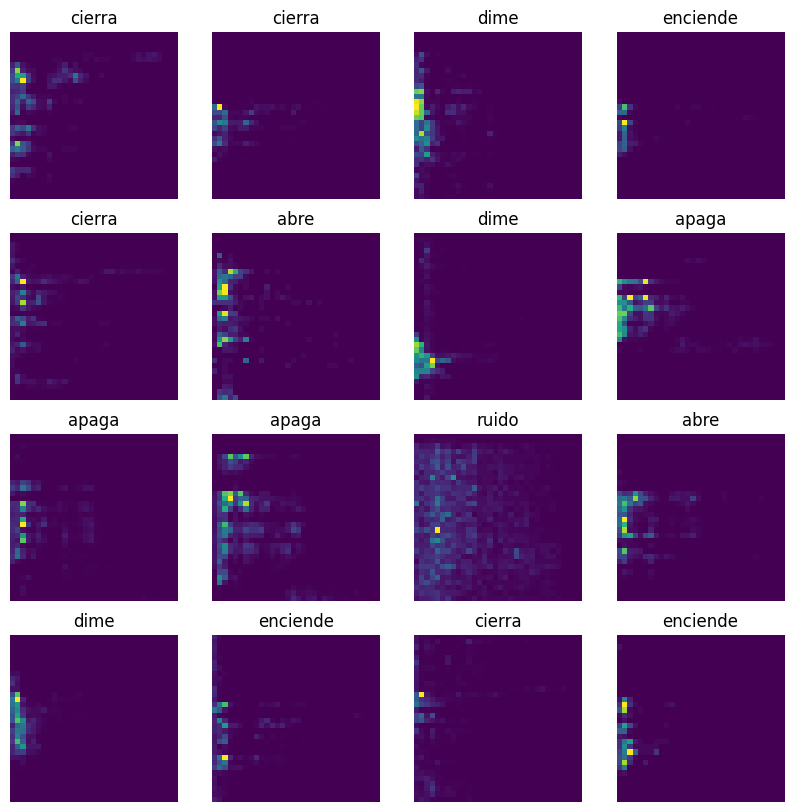

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
num_classes = 6

initializer = tf.keras.initializers.HeNormal()
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(32, 32, 1)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  # tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
  # tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
  # tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [16]:
# Establecer el learning_rate, la función loss_fn, el optimizador y las métricas.
learning_rate = 0.0005
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [19]:
# Creación de callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitoriza la pérdida de validación
    patience=3,          # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaura los mejores pesos encontrados
)

model_checkpoint = ModelCheckpoint(
    filepath='mejor_modelo.keras',  # Ruta para guardar el modelo
    monitor='val_accuracy',      # Monitoriza la precisión de validación
    save_best_only=True         # Guarda solo el mejor modelo
)

# Almacena class_names antes de dividir el conjunto de datos
# class_names = train_ds.class_names

# Divide el conjunto de datos en conjuntos de entrenamiento y validación
validation_split = 0.1781
num_validation_samples = int(len(train_ds) * validation_split)
validation_ds = train_ds.take(num_validation_samples)
train_ds = train_ds.skip(num_validation_samples)

epochs = 100
print('\nFitting:')

# Entrenar el modelo
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[early_stopping, model_checkpoint])


Fitting:
Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.2097 - loss: 2.0513 - val_accuracy: 0.4509 - val_loss: 1.7936
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.3497 - loss: 1.8151 - val_accuracy: 0.5580 - val_loss: 1.4762
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4790 - loss: 1.5843 - val_accuracy: 0.6607 - val_loss: 1.1685
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5197 - loss: 1.4134 - val_accuracy: 0.7857 - val_loss: 1.0524
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6317 - loss: 1.1790 - val_accuracy: 0.7946 - val_loss: 0.8926
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.6985 - loss: 1.0053 - val_accuracy: 0.7991 - val_loss: 0.9234
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.7343 - loss: 0.9420 - val_accuracy: 0.8304 - val_loss: 0.7844
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8028 - loss: 0.8023 - val

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 640,580 (2.44 MB)

 Trainable params: 213,526 (834.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 427,054 (1.63 MB)

In [21]:
# Evaluar el mejor modelo en el conjunto de datos de prueba
best_model = tf.keras.models.load_model('mejor_modelo.keras')
loss, accuracy = best_model.evaluate(test_ds)
print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Precisión en el conjunto de prueba: {accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8872 - loss: 0.5622
Pérdida en el conjunto de prueba: 0.5636345148086548
Precisión en el conjunto de prueba: 0.8931623697280884


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Puntuación F1: 0.8932353716201522
Precisión: 0.8940921473816211
Recall: 0.8931623931623932
Accuracy: 0.8931623931623932


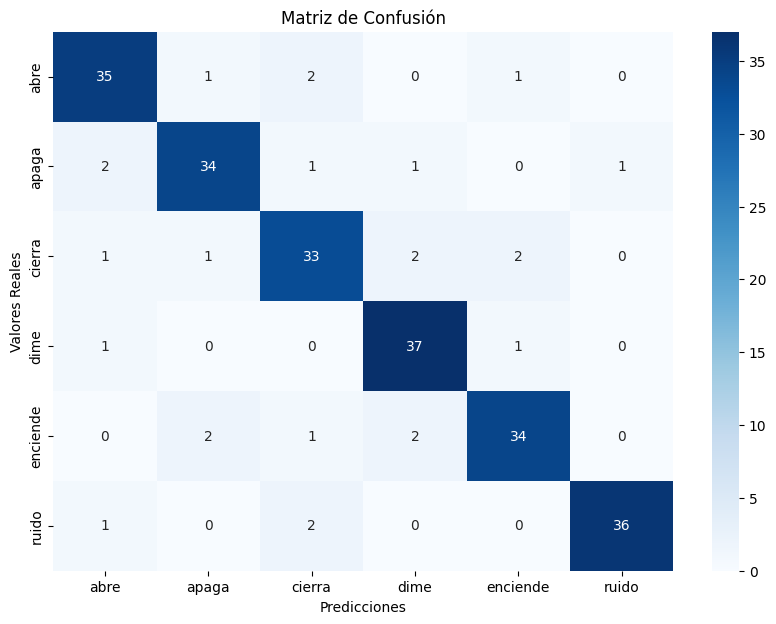

In [22]:
# Extraer y_true antes de hacer predicciones
y_true = np.concatenate([y for _, y in test_ds.as_numpy_iterator()], axis=0)

# Luego, obtener las predicciones
y_pred_probs = best_model.predict(test_ds)  # Obtén las probabilidades de predicción
y_pred = np.argmax(y_pred_probs, axis=1) # Obtén las etiquetas predichas

# Calcular las métricas
f1 = f1_score(y_true, y_pred, average='macro')  # 'weighted' para promediar por clase
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred,average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"Puntuación F1: {f1}")
print(f"Precisión: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

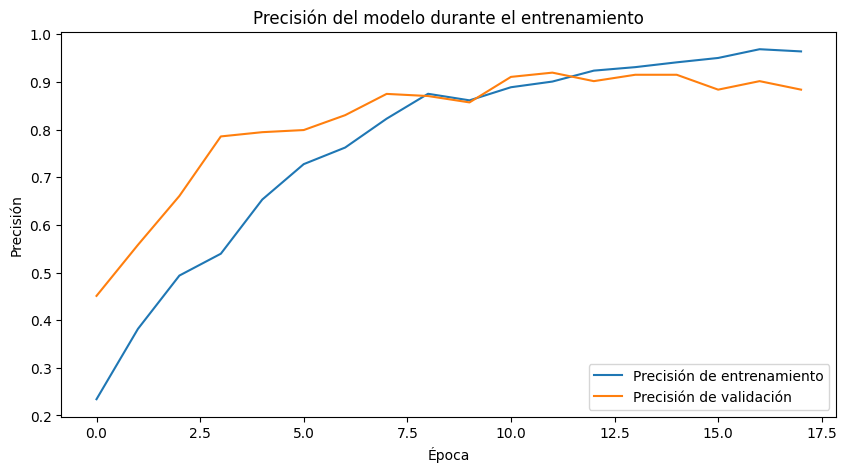

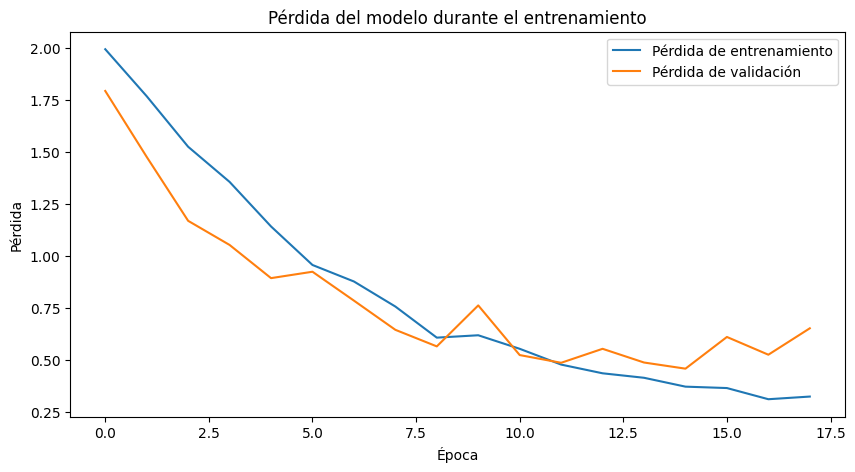

In [23]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#graficar el train accuracy y validation accuracy vs las épocas de entrenamiento
plt.figure(figsize=(10, 5))  # Ajusta el tamaño de la figura si es necesario
plt.plot(training_accuracy, label='Precisión de entrenamiento')
plt.plot(validation_accuracy, label='Precisión de validación')
plt.title('Precisión del modelo durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

#graficar el train loss y validation loss vs las épocas de entrenamiento
plt.figure(figsize=(10, 5))  # Ajusta el tamaño de la figura si es necesario
plt.plot(training_loss, label='Pérdida de entrenamiento')
plt.plot(validation_loss, label='Pérdida de validación')
plt.title('Pérdida del modelo durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend(loc='upper right')
plt.show()